# 13.1 正态性检验 
正态分布是金融学中最重要的分布之一，也是金融理论的主要统计学基础之一。

### 投资组合理论
当组合中的每个资产收益率呈现 **正态分布时** ，可以将期望效用泰勒展开，这时组合的效用只与组合的收益率&方差有关

### 资本资产定价模型
当股票收益呈正态分布时，单独证券的价格可以很好地用和某种大规模市场指数的关系表示；这种关系通常用单一股票与市场指数的联动指标（β）表示。

### 有效市场假设
有效市场指的是价格反映所有可用信息的市场，其中的“所有”可以是狭义的，也可以是广义的（例如“所有公开信息”或者同时包括“只为个人所有”的信息）。如果这个假设成立，股票价格波动将是随机的，而收益呈正态分布。

### 期权定价理论
Black- Scholes-Merton期权定价公式使用几何布朗运动作为股票在一段时间内随机波动的模型，这种波动造成收益呈正态分布。

## 13.1.1 基准案例(用几何布朗运动)
几何布朗运动中的路径特性，说明如下： \
1. 正态对数收益率\
在两个时间点之间的对数收益率呈正态分布。
$$\log \frac { S t } { S _ { s } } = \log S _ { t } - \log S _ { s } ( 0 \lt S \lt t )$$
2. 对数-正态价值\
在任何时间点t > 0，价值St呈正态分布。


### step1 导入库 

In [1]:
import math
import numpy as np
import scipy.stats as scs
import statsmodels.api as sm
from pylab import mpl, plt

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

### step2 为几何布朗运动生成蒙特卡洛路径 （参见第十二章），并模拟数据

In [2]:
def gen_paths(S0, r, sigma, T, M, I):
    dt = T / M  # T总时间，M时间间隔数量
    paths = np.zeros((M + 1, I)) # I是模拟路径的数量
    paths[0] = S0
    for t in range(1, M + 1):
        rand = np.random.standard_normal(I) # 生成I个符合正态分布数据
        rand = (rand - rand.mean()) / rand.std() #  匹配一阶矩、二阶矩 （参见第12章）
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt
                                        + sigma * math.sqrt(dt) * rand) # 几何布朗运动欧拉离散
    return paths

In [3]:
S0 = 100. # 初始价格
r = 0.05 # 恒定短期利率
sigma = 0.2 # 恒定波动率因子
T = 1.0 # 以年表示的时间范围
M = 50 # 50个时间间隔 
I = 250000 # 模拟过程的数量
np.random.seed(1000)
paths = gen_paths(S0, r, sigma, T, M, I)
S_e = S0 * math.exp(r * T) # 预期ST价值
S_s = paths[-1].mean() # 模拟的ST平均值
print(f'预期价值{S_e}')
print(f'模拟的ST平均值{S_s}')

预期价值105.12710963760242
模拟的ST平均值105.12645392478755


Text(0, 0.5, 'index level')

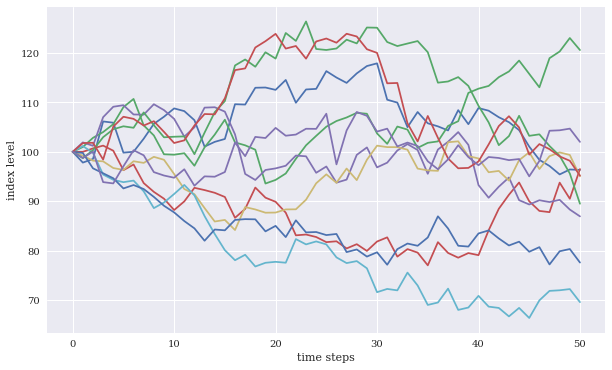

In [4]:
plt.figure(figsize=(10,6))
plt.plot(paths[:,:10])
plt.xlabel('time steps')
plt.ylabel('index level')

### step3：模拟路径和结果对数收益率

In [5]:
paths[:, 0].round(4)
log_returns = np.log(paths[1:] / paths[:-1])#求对数收益率，log(St/St-1)
log_returns[:, 0].round(4)# 

array([-0.022 ,  0.0075,  0.0743, -0.0024, -0.059 ,  0.0018,  0.0261,
        0.0289,  0.0136,  0.0156, -0.0051, -0.0171, -0.0516,  0.0095,
        0.0057,  0.0663, -0.0006,  0.0306,  0.0004, -0.0042,  0.0177,
       -0.0411,  0.0241,  0.0011,  0.0314, -0.0112, -0.0095,  0.0167,
        0.0128,  0.0047, -0.0645, -0.0053, -0.0463,  0.0288, -0.0214,
       -0.0059, -0.0079,  0.0386, -0.0266,  0.0305, -0.0049, -0.0123,
       -0.0094, -0.0153, -0.0324, -0.0269, -0.0127, -0.0178,  0.0104,
       -0.0009])

In [6]:
def print_statistics(array):    
    sta = scs.describe(array)
    print('%14s %15s' % ('statistic', 'value'))
    print(30 * '-')
    print('%14s %15s' % ('size', sta[0]))
    print('%14s %15s' % ('min', sta[1][0]))
    print('%14s %15s' % ('max', sta[1][1]))
    print('%14s %15s' % ('mean', sta[2]))
    print('%14s %15s' % ('std', np.sqrt(sta[3])))
    print('%14s %15s' % ('skew', sta[4]))
    print('%14s %15s' % ('kurtosis', sta[5]))

In [7]:
print_statistics(log_returns.flatten())

     statistic           value
------------------------------
          size        12500000
           min -0.15663811221692664
           max 0.15370656604352606
          mean 0.0006000000000000011
           std 0.02828427237883284
          skew 0.0005468217956237646
      kurtosis 0.0008466944573917168


 年化对数收益率&年化标准差

In [8]:
log_returns.mean() * M + 0.5 * sigma ** 2 #按照伊藤公式校正的年化对数收益率均值

0.05000000000000006

In [9]:
log_returns.std() * math.sqrt(M) # 对数收益的年化标准差

0.20000000000000015

### step4：正态性检验

### 图形化检验正态性

#### （1）对比频率分布（直方图）与理论化PDF
模拟对数收益率的频率分布以及参数化r和sigma之后的正态分布概率密度函数（PDF）的对比 

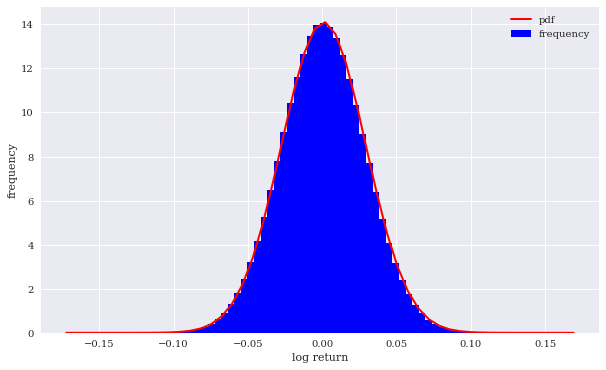

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(log_returns.flatten(), bins=70, density=True,stacked=True,
        label='frequency', color='b')
plt.xlabel('log return')
plt.ylabel('frequency')
x = np.linspace(plt.axis()[0], plt.axis()[1])
plt.plot(x, scs.norm.pdf(x, loc=r / M, scale=sigma / np.sqrt(M)),
                        'r', lw=2.0, label='pdf')
plt.legend()

#### (2) 用QQ图检验正态性
对样本分位数值与理论分位数值进行对比。对于正态分布的样本数据集，QQ图如图所示，绝大多数分位数值（点）位于一条直线上：

Text(0, 0.5, 'sample quantiles')

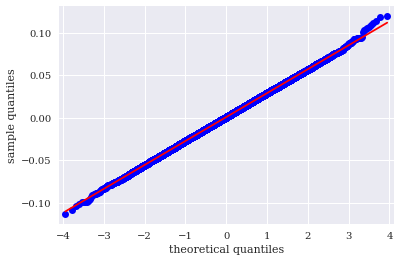

In [11]:
sm.qqplot(log_returns.flatten()[::500], line='s')
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles')

### 统计学测试正态性 
1. 偏斜度测试（skewtest()）\
测试样本数据的偏斜是否“正态”（也就是值足够接近0）。
2. 峰度测试（kurtosistest()）\
与偏斜度测试类似，测试样本数据的峰度是否“正态”（同样是值足够接近0）。
3. 组合其他两种测试方法，检验正态性。
4. 其他测试方法参考博客 \
https://blog.csdn.net/QimaoRyan/article/details/72861387?spm=1001.2101.3001.6650.4&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-4.pc_relevant_aa&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-4.pc_relevant_aa&utm_relevant_index=9

In [14]:
def normality_tests(arr):
    print('Skew of data set %14.3f' % scs.skew(arr))#偏度，接近0更好
    print('Skew test p-value %14.3f' % scs.skewtest(arr)[1])# skewtest的第二个统计量是P值
    print('Kurt of data set %14.3f' % scs.kurtosis(arr))#峰度
    print('Kurt test p-value %14.3f' % scs.kurtosistest(arr)[1])#第二个统计量是P值
    print('Norm test p-value %14.3f' % scs.normaltest(arr)[1])#检验正态性
normality_tests(log_returns.flatten())

Skew of data set          0.001
Skew test p-value          0.430
Kurt of data set          0.001
Kurt test p-value          0.541
Norm test p-value          0.607


### 怎么看统计测试正态性的结果?
null hypothesis: x comes from a normal distribution \
`if p < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")`

## 13.1.2 真实数据

导入数据

In [39]:
import tushare as ts
import pandas as pd
pro = ts.pro_api('13c62fc6e94c961a37a2816bd73036551e00122be3c051f44c649d2b')
#多个股票
sz1 = pro.daily(ts_code='000001.SZ', start_date='20200701', end_date='20220301')
sz2 = pro.daily(ts_code='000002.SZ', start_date='20200701', end_date='20220301')
sh0 = pro.daily(ts_code='600000.SH', start_date='20200701', end_date='20220301')
data = pd.DataFrame()
data['000001.SZ']=sz1['close']
data['000002.SZ']=sz2['close']
data['600000.SH']=sh0['close']
data['trade_date'] = sz1['trade_date']
data['trade_date'] = pd.to_datetime(data['trade_date'])
data.index = data['trade_date']
data= data.drop(['trade_date'],axis=1)
data.head()

,000001.SZ,000002.SZ,600000.SH
trade_date,,,
2022-03-01,15.92,19.38,8.44
2022-02-28,15.75,19.20,8.39
2022-02-25,15.90,19.53,8.43
2022-02-24,15.91,19.84,8.44
2022-02-23,16.19,20.26,8.54


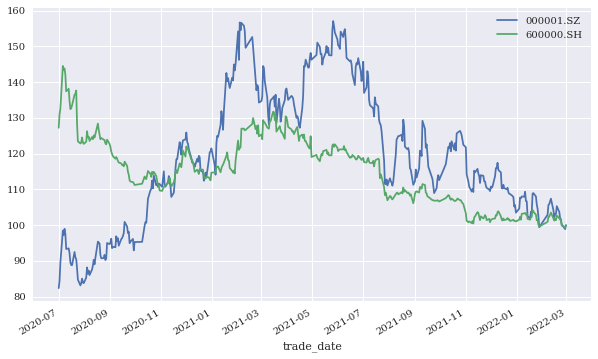

In [21]:
(data / data.iloc[0] * 100).plot(figsize=(10, 6))# 金融工具在一段时间内的规格化价格

金融工具对数回报率的直方图

In [40]:
log_returns = np.log(data / data.shift(1))
log_returns.head()

,000001.SZ,000002.SZ,600000.SH
trade_date,,,
2022-03-01,NaN,NaN,NaN
2022-02-28,-0.010736,-0.009331,-0.005942
2022-02-25,0.009479,0.017041,0.004756
2022-02-24,0.000629,0.015748,0.001186
2022-02-23,0.017446,0.020948,0.011779


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021F831CA8B0>,
      dtype=object)

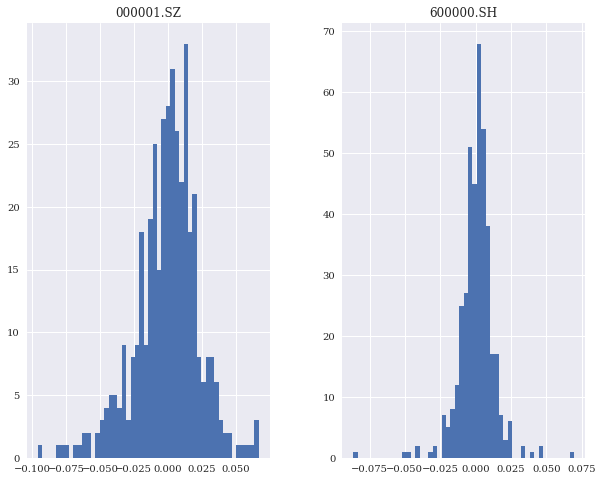

In [23]:
log_returns.hist(bins=50, figsize=(10, 8))

### 计算统计量

In [68]:
symbols=['000001.SZ','000002.SZ','600000.SH']
for sym in symbols:
    print(f'\nResults for symbol{sym}')
    print(30 * '-')
    log_data = np.array(log_returns[sym].dropna())
    print_statistics(log_data)


Results for symbol000001.SZ
------------------------------
     statistic           value
------------------------------
          size             404
           min -0.09562910820760229
           max 0.06686294522912667
          mean -0.00047880791311954144
           std 0.023468174892868027
          skew -0.5029407723292967
      kurtosis 1.4260293870474046

Results for symbol000002.SZ
------------------------------
     statistic           value
------------------------------
          size             404
           min -0.09534049247957241
           max 0.08047720691999859
          mean 0.0009187426600334932
           std 0.02163211239350361
          skew -0.3400959991816087
      kurtosis 2.747407767485715

Results for symbol600000.SH
------------------------------
     statistic           value
------------------------------
          size             404
           min -0.08641542941537697
           max 0.06948475541226504
          mean 0.0005965167833486492
       

### 用QQ图检验正态性

Text(0, 0.5, 'sample quantiles')

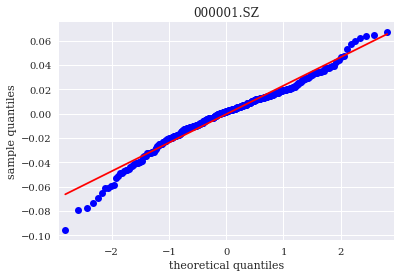

In [69]:
sm.qqplot(log_returns['000001.SZ'].dropna(), line='s')
plt.title('000001.SZ')
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles')

Text(0, 0.5, 'sample quantiles')

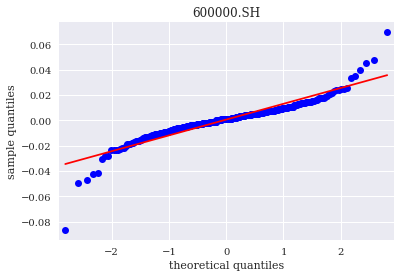

In [70]:
sm.qqplot(log_returns['600000.SH'].dropna(), line='s')
plt.title('600000.SH')
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles')

### 统计正态性检验 (P值为0，否决原假设正态分布)

In [67]:
for sym in symbols:
    print(f'\nResults for symbol{sym}')
    print(30 * '-')
    log_data = np.array(log_returns[sym].dropna())
    normality_tests(log_data)


Results for symbol000001.SZ
------------------------------
Skew of data set         -0.503
Skew test p-value          0.000
Kurt of data set          1.426
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol000001.SZ
------------------------------
Skew of data set         -0.503
Skew test p-value          0.000
Kurt of data set          1.426
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol600000.SH
------------------------------
Skew of data set         -0.609
Skew test p-value          0.000
Kurt of data set          9.529
Kurt test p-value          0.000
Norm test p-value          0.000


# 13.2 投资组合优化
MPT的基本思路是通过分散投资实现投资组合风险最小化，或者在指定风险水平下的组合收益最大化。 \
以三种风险资产为例000001.SZ,000002.SZ,600000.SH


In [80]:
rets = log_returns.dropna()
rets.describe()

,000001.SZ,000002.SZ,600000.SH
count,404.000000,404.000000,404.000000
mean,-0.000479,0.000919,0.000597
std,0.023468,0.021632,0.012482
min,-0.095629,-0.095340,-0.086415
25%,-0.011966,-0.009312,-0.004670
50%,0.001799,0.001197,0.001038
75%,0.013423,0.012903,0.006636
max,0.066863,0.080477,0.069485


In [72]:
rets.cov()

,000001.SZ,000002.SZ,600000.SH
000001.SZ,0.000551,0.000240,0.000177
000002.SZ,0.000240,0.000468,0.000124
600000.SH,0.000177,0.000124,0.000156


## 13.2.1用蒙特卡洛模拟可能风险资产组合 

In [73]:
def port_ret(weights):
    return np.sum(rets.mean() * weights) * 252 #算组合年化收益率
def port_vol(weights):
    return np.sqrt(np.dot(weights.T,np.dot(rets.cov() * 252, weights))) #算组合的标准差
prets = []
pvols = []
noa = len(symbols)# 金融工具的数量
for p in range(2500):
    weights = np.random.random(noa) #组合权重的蒙特卡罗模拟
    weights /= np.sum(weights)
    prets.append(port_ret(weights))#将组合的return收集在列表
    pvols.append(port_vol(weights))#将组合标准差收集在列表
prets = np.array(prets)#转化成array对象
pvols = np.array(pvols)

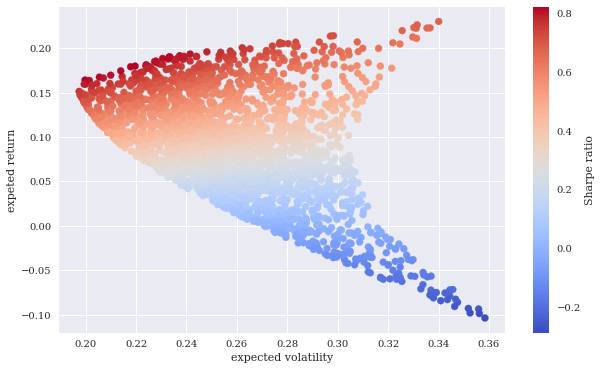

In [74]:
plt.figure(figsize=(10,6))
plt.scatter(pvols, prets, c=prets / pvols,
           marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expeted return')
plt.colorbar(label='Sharpe ratio')

## 13.2.3 最优投资组合(分别找夏普比率最大&标准差最小的portfolio)

1. 目标：最大化夏普指数，即最小化夏普指数负值（书中Sharpe ratio分子未减Rf）
2. 约束：\
   权重和为1\
   每个资产权重在（0，1）之间


In [75]:
import scipy.optimize as sco #引入最小化函数
def min_func_sharpe(weights):
    return -port_ret(weights) / port_vol(weights) # 需要最小化的函数
cons = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1})#等式约束
bnds = tuple((0,1) for x in range(noa)) # 参数范围
eweights = np.array(noa * [1. / noa,]) #等权重向量，对权重的初始猜测
min_func_sharpe(eweights)# 返回最优参数值

-0.34629155435318987

In [76]:
opts = sco.minimize(min_func_sharpe,eweights,
                   method='SLSQP', bounds=bnds, constraints=cons)# 将最小化函数结果储存在opts
opts#最优化结果

     fun: -0.8426257931365462
     jac: array([ 1.55522414e+00, -3.04326415e-04,  1.27226114e-04])
 message: 'Optimization terminated successfully'
    nfev: 28
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.        , 0.29481342, 0.70518658])

目标：最优化方差，即最小化波动率

In [77]:
optv = sco.minimize(port_vol,eweights,
                   method='SLSQP', bounds=bnds, constraints=cons)# 将最小化函数结果储存在opts
optv

     fun: 0.19642583421867227
     jac: array([0.23397576, 0.19604377, 0.19646072])
 message: 'Optimization terminated successfully'
    nfev: 20
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.        , 0.08365921, 0.91634079])

## 13.2.4 有效边界 (书中用相同收益率下波动率最小化来确定)
并在图中分别标出夏普比率最大&风险最小的投资组合
$$注意书中的Sharpe Ratio并未减去R_f$$

In [98]:
cons = ({'type':'eq','fun':lambda x:port_ret(x) - tret},
       {'type': 'eq', 'fun':lambda x: np.sum(x) - 1}) #有效边界的两个约束
bnds = tuple((0, 1) for x in weights) #参数范围
eweights = np.array(noa * [1. / noa,]) #等权重向量
trets = np.linspace(prets.min(), prets.max(), 200) # 固定组合收益率水平
tvols = []
for tret in trets:
    res = sco.minimize(port_vol, eweights, method='SLSQP',
                      bounds=bnds,
                      constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

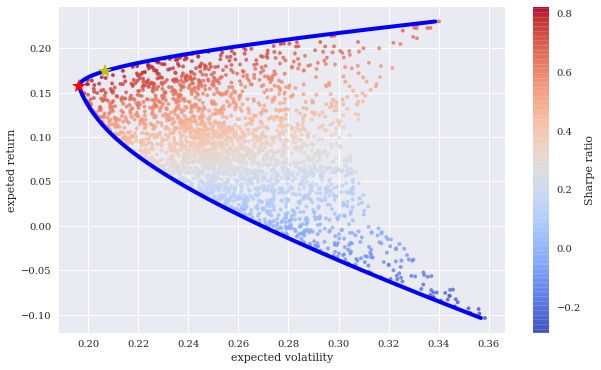

In [95]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols,
           marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(opts['x']), port_ret(opts['x']),
        'y*', markersize=15.0)
plt.plot(port_vol(optv['x']), port_ret(optv['x']),
        'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expeted return')
plt.colorbar(label='Sharpe ratio')

## 13.2.5 资本市场线 (过无风险资产点&与有效前沿相切的线)
设$$ r_f = 0.01 $$

In [96]:
import scipy.interpolate as sci
ind = np.argmin(tvols)# 最小波动率投资组合的指数头寸
evols = tvols[ind:] # 相关组合波动率
erets = trets[ind:] #相关组合回报率


In [99]:
tck = sci.splrep(evols, erets)#3次样条插值

In [100]:
def f(x): # 求有效前沿的函数f(x)
    return sci.splev(x, tck, der=0)
def df(x): # 求有效前沿函数一阶导
    return sci.splev(x, tck, der=1)

### 求资本市场线
数学条件如下： \
$$ t(x)=a+b \cdot x $$ 
$$ t(0)=r_{f} \quad \Leftrightarrow \quad a=r_{f} $$
$$ t(x)=f(x) \quad \Leftrightarrow \quad  a+ b \cdot x=f(x) $$
$$ t^{\prime}(x)=f^{\prime}(x) \quad \Leftrightarrow \quad b=  f^{\prime}(x) $$
定义参数集：$$ p =(a, b, x)$$

In [151]:
def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3
opt = sco.fsolve(equations, [0.01, 0.4, 0.195])#给定初始解,可以通过有效前沿大致猜测
opt

array([0.01      , 0.79443768, 0.20825343])

In [152]:
np.round(equations(opt))

array([ 0.,  0., -0.])

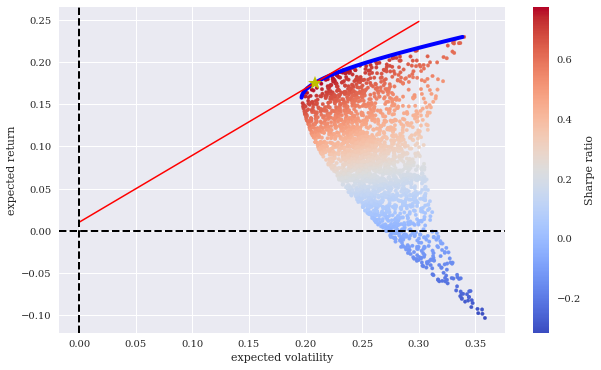

In [153]:
plt.figure(figsize=(10,6))
plt.scatter(pvols, prets, c=(prets - 0.01) / pvols,
           marker = '.', cmap='coolwarm')
plt.plot(evols, erets, 'b', lw=4.0)
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx,
        'r', lw=1.5)
plt.plot(opt[2], f(opt[2]), 'y*', markersize=15.0)
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

### 求最优组合(与CML相切组合)中各资产权重、组合return&risk 

In [161]:
cons = ({'type':'eq', 'fun': lambda x:port_ret(x) - f(opt[2])},
       {'type':'eq', 'fun': lambda x: np.sum(x) - 1})
res = sco.minimize(port_vol, eweights, method='SLSQP',
                  bounds=bnds, constraints=cons)
w = res['x']
print(f'最优组合各权重分别为{w}')
print(f'最优组合收益率为{port_ret(w)}')
print(f'最优组合标准差为{port_vol(w)}')

最优组合各权重分别为[0.         0.30938247 0.69061753]
最优组合收益率为0.17544437083983955
最优组合标准差为0.2082534715352331


# 13.3 贝叶斯统计 
贝叶斯公式在金融学中常见的解读是历时解读。这主要说明，随着时间的推移，我们会了解感兴趣的变量或者参数的新信息，例如时间序列的平均收益率。

## 13.3.1 贝叶斯公式
贝叶斯公式是由条件概率推过来的，条件概率是正逻辑，在A条件下发生B的概率。贝叶斯公式是逆逻辑，即B发生了，A发生的概率。
贝叶斯公式中的信息调整因子，会随着新的信息不断更新。分子是条件概率，分母用全概率公式（条件概率和乘法法则）。

$$
p(H \mid D)=\frac{p(H) \cdot p(D \mid H)}{p(D)}
$$
式中 H表示某个事件（假设），D代表实验或者真实世界可能提供的数据。
$$ 在这些定义的基础上，我们得到:$$
$$ p(H)  称作先验概率；$$
$$ p(D)  是任何假设下数据的概率，称作标隹化常数；$$
$$ p(D \mid H)  是假设H下数据的似然度（即概率）；$$
$$ p(H\mid D)  是后验概率，即我们看到数据之后得出的
概率。$$

## 13.3.2 贝叶斯回归 

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

In [6]:
# 设置绘图样式
plt.style.use('seaborn') 
# 正常显示中文
mpl.rcParams['font.sans-serif'] =['Microsoft YaHei']
#生成确定的随机数
np.random.seed(1000)
# 内嵌画图，可省去一些指令,如plt.show()
%matplotlib inline 

### (1)导入数据&使用普通最小二乘回归

回归方程为 
1.988 x + 4.075


Text(0, 0.5, 'y')

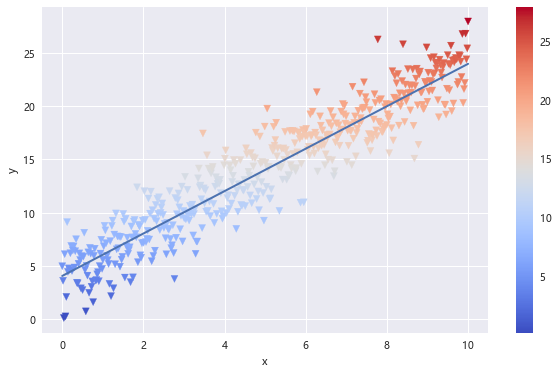

In [12]:
x = np.linspace(0, 10, 500)

# 生成基于直线的噪声数据
y = 4 + 2 * x + np.random.standard_normal(len(x)) * 2 

# 回归
reg = np.polyfit(x, y, 1)  # np.polyfit得到对应阶数的拟合函数各项式系数,顺序由高阶到低阶
y_fit = np.poly1d(reg) # 查看拟合函数，是1d的数字1，不是字母L
print(f'回归方程为{y_fit}')


#画图
plt.figure(figsize=(10,6))
plt.scatter(x, y, c=y,#颜色
            marker='v',#标记
            cmap='coolwarm'#颜色映射
           )#画散点图
plt.plot(x, y_fit(x), lw=2.0)#画回归直线,lw是线宽
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

### (2) 使用贝叶斯回归
$$ \hat{y}(x)=\alpha+\beta \cdot x $$ 
先验概率如下： 
1. 假定参数分布如下: \
α呈正态分布，均值为0，标准差为20；\
β呈正态分布，均值为0，标准差为10。
2. 似然度  
假定一个均值为$ \hat{y}(x)$的正态分布 \
和一个标准差为0～10之间的均匀分布

贝叶斯回归的一个要素是（马尔科夫链）蒙特卡洛（MCMC）采样，技术性采样有3个不同的函数可以调用： 
1. find_MAP()通过求取局部最大后验点来寻找采样算法的起点
2. NUTS()为假定先验概率的MCMC采样实现所谓的“高效双平均无回转采样器”（NUTS）算法
3. sample()以给定起始值（来自find_MAP()）和最优化步长（来自NUTS算法）提取一定数量的样本 \
<span style="border-bottom:3px dashed #DE7171;">以上都包装到一个PyMC3 Model对象中，并在with语句中执行</span>

In [15]:
import pymc3 as pm

In [34]:
with pm.Model() as model:
    # 设定参数分布(定义先验概率)
    alpha = pm.Normal('alpha', mu=0, sd=20)# 均值为0，标准差为20的正态分布
    beta = pm.Normal('beta', mu=0, sd=10)# 均值为0，标准差为10的正态分布
    sigma = pm.Uniform('sigma', lower=0, upper=10)#为0～10之间的均匀分布
    
    #指定线性回归
    y_est = alpha + beta * x # 假定参数分布后的y
    
    #定义似然度
    likehood = pm.Normal('y', mu=y_est, sd=sigma, observed=y) 
    '''observed=y是告诉模型这个变量的值已经被观测到，
    不会被拟合算法改变，观测值y是我们开始定义的y'''
    
    # inference
    start = pm.find_MAP()#通过优化找出起始值
    step = pm.NUTS()#实例化MCMC算法
    trace = pm.sample(50, tune=100, start=start,
                     progressbar=True)#用NUTS取得后验样本

D:\Anaconda\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
D:\Anaconda\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


<ipython-input-34-c1a0de7d310c>:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(50, tune=100, start=start,
Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 100 tune and 50 draw iterations (400 + 200 draws total) took 271 seconds.
D:\Anaconda\lib\site-packages\pymc3\sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
The acceptance probability does not match the target. It is 0.9392378252450816, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9617807841336706, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9342892154432455, but should be close to 0.8. Try to increase the number of tuning steps.


### 后验分析

1. 文字形式后验统计总结

In [25]:
pm.summary(trace)

D:\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,4.072,0.176,3.812,4.426,0.021,0.015,74.0,39.0,1.06
beta,1.988,0.031,1.926,2.041,0.003,0.002,100.0,125.0,1.01
sigma,2.033,0.055,1.950,2.143,0.005,0.004,122.0,105.0,1.10


In [26]:
trace[0]

{'alpha': 3.915926769287555,
 'beta': 2.0148379810277555,
 'sigma_interval__': -1.392008385977773,
 'sigma': 1.990873230236645}

2. 绘制后验采样趋势图

<ipython-input-33-83f678f91c14>:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
D:\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013C065BB970>,
      dtype=object)

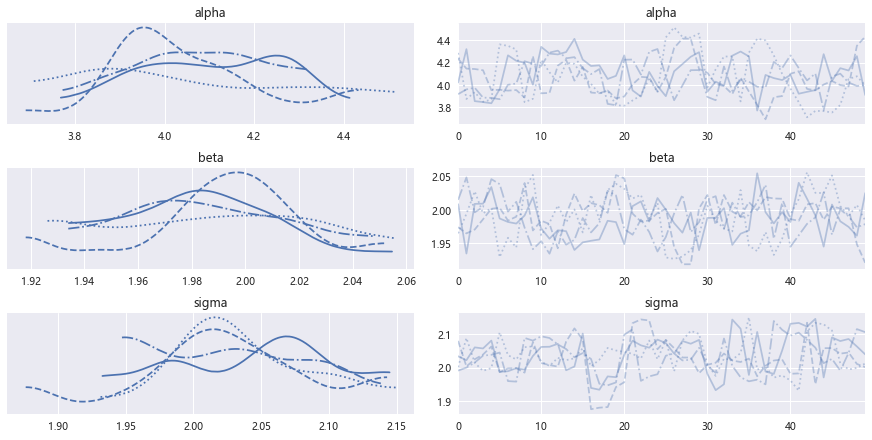

In [33]:
# 估算值轨迹图
pm.traceplot(trace)

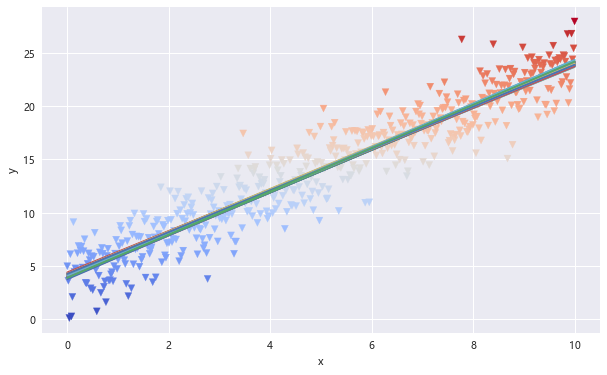

In [30]:
#绘制所有的结果回归线
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
plt.colorbar
plt.xlabel('x')
plt.ylabel('y')
for i in range(len(trace)):
    plt.plot(x, trace['alpha'][i] + trace['beta'][i] * x)

# 13.4 两种金融工具 

## 13.4.1 无监督学习 
训练样本的标记信息未知，目标是通过对无标记训练样本的学习来揭示数据的内在性质和规律，此类学习任务研究最多的时‘聚类’（clustering）。
k-均值（K-means）聚类就是这样的算法，它将原始数据集分为多个聚类，为这些子集分配标签（“聚类0”“聚类1”等）。另一个算法是高斯混合。

聚类和分类不同，分类是已知类型，聚类未知，有些时候聚类可以作为分类学习任务的前驱过程。如商家需要对新用户的类型进行判别，但是定义‘用户类型’对商家可能不太容易，可以先进行聚类，将聚类结果的簇定义为一类，然后在基于类训练分类模型，用于判别新用户类型。

### （1) 数据

In [11]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
np.random.seed(1000)
np.set_printoptions(suppress=True, precision=4)
%matplotlib inline

In [6]:
from sklearn.datasets.samples_generator import make_blobs
# 创建聚类样本数据，250个样本和4个中心
X, y = make_blobs(n_samples=250,#样本数
                  n_features=3,#每个样本特征数量
                  centers=4, #中心个数
                  random_state=50, #为多个函数调用传递可重复输出的int值,确定的随机数种子
                  cluster_std=1.25)

X数组形状为[n_samples,n_features] \
y数组形状为[n_samples]

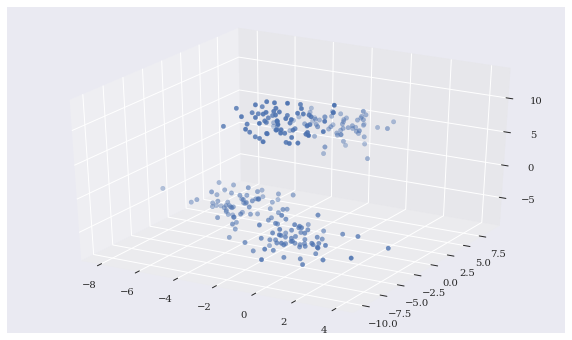

In [7]:
# 聚类数据可视化
from mpl_toolkits.mplot3d import Axes3D
fig =plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2])

### (2) k means聚类

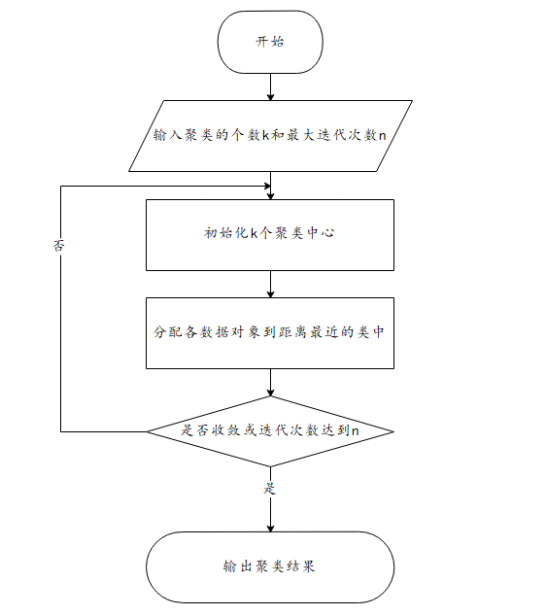
1. 优点：
（1）算法简单、快速。\
（2）对处理大数据集，该算法是相对高效率的。\
2. 缺点：
（1）要求用户必须事先给出要生成的簇的数目K。 \
（2）对初值敏感。\
（3）对于孤立点数据敏感。
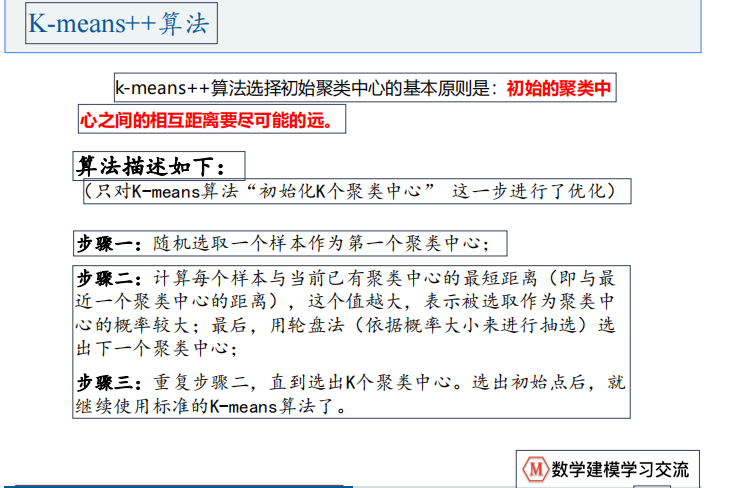

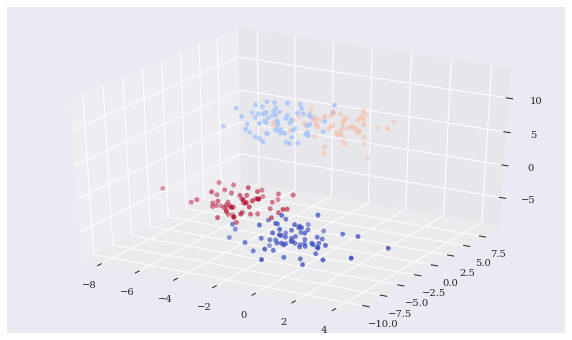

In [17]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=4, random_state=0)
model.fit(X)
KMeans(algorithm='auto', copy_x=True, 
       init='k-means++',# 初始值的选择方式，k-means++选择聚类中心原则是初始聚类中心相互距离尽可能远
       max_iter=300,# 当数据集不收敛时，迭代次数到300自动退出循环
      n_clusters=4, #聚类的数量
       n_init=10, # 用不同的初始化质心运行算法的次数，减少受初始值的影响
       n_jobs=None,
       precompute_distances='auto', 
      random_state=0, 
       tol=0.0001, verbose=0)
y_kmeans = model.predict(X) #对每个样本进行分类[0,1,2,3]
fig =plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2], c=y_kmeans, cmap='coolwarm')

### (3) 高斯混合
参考链接
[https://blog.csdn.net/lotusng/article/details/79990724](https://blog.csdn.net/lotusng/article/details/79990724)

In [18]:
from sklearn.mixture import GaussianMixture

In [19]:
model = GaussianMixture(n_components=4, random_state=0)
model.fit(X)

GaussianMixture(n_components=4, random_state=0)

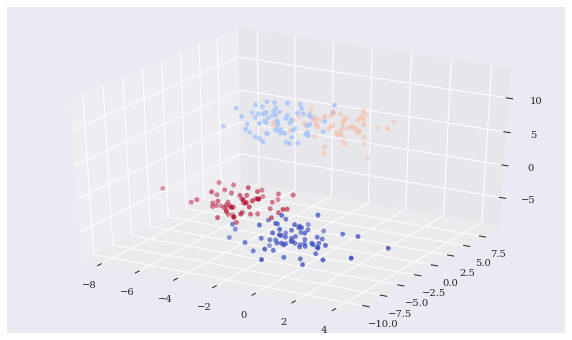

In [20]:
y_gm = model.predict(X) #给样本打上分类标签[0,1,2,3]
fig =plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2], c=y_gm, cmap='coolwarm')

## 13.4.2 有监督学习 
有监督学习是具有某种指导（形式是已知的结果或者观测数据）的机器学习方法。这意味着，原始数据中已经包含了ML算法打算学习的东西。\
以分类任务为例，有监督学习中的分类标签已经给出，因此算法可以学习特征与类别（分类）之间的关系。换言之，在拟合步骤中，算法知道给定特征值组合的正确分类。

### （1）数据
make_classification使用文档 \
[[https://blog.csdn.net/weixin_44225602/article/details/122726227?spm=1001.2101.3001.6650.12&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-12.pc_relevant_default&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-12.pc_relevant_default&utm_relevant_index=13](https://blog.csdn.net/weixin_44225602/article/details/122726227?spm=1001.2101.3001.6650.12&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-12.pc_relevant_default&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-12.pc_relevant_default&utm_relevant_index=13)]([https://blog.csdn.net/weixin_44225602/article/details/122726227?spm=1001.2101.3001.6650.12&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-12.pc_relevant_default&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-12.pc_relevant_default&utm_relevant_index=13](https://blog.csdn.net/weixin_44225602/article/details/122726227?spm=1001.2101.3001.6650.12&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-12.pc_relevant_default&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-12.pc_relevant_default&utm_relevant_index=13))

In [14]:
from sklearn.datasets import make_classification
n_samples = 100
X, y = make_classification(n_samples=n_samples, #样本数量
                           n_features=2,#总的特征数量
                          n_informative=2,#信息特征的数量
                          n_redundant=0,#冗余特征的数量
                          n_repeated=0,#从信息特征和冗余特征中随机抽取的重复特征的数量
                          random_state=250)#类似随机种子，复现随机数

In [24]:
X[:5]#前五个样本数据

array([[ 1.6876, -0.7976],
       [-0.4312, -0.7606],
       [-1.4393, -1.2363],
       [ 1.118 , -1.8682],
       [ 0.0502,  0.659 ]])

In [25]:
y[:5]#前5个样本标签

array([1, 0, 0, 1, 1])

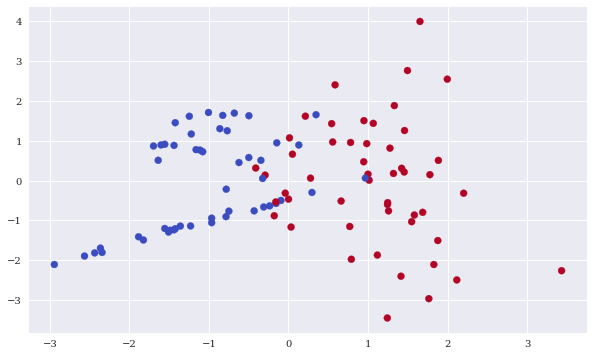

In [26]:
plt.figure(figsize=(10,6))
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap='coolwarm')

### (2)高斯朴素贝叶斯 （GNB）

掉包实现GBNB

In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [30]:
model = GaussianNB()
model.fit(X, y)
GaussianNB(priors=None, var_smoothing=1e-09)
model.predict_proba(X).round(4)[:5] #显示算法在拟合之后为每个类指定的概率

array([[0.0041, 0.9959],
       [0.8534, 0.1466],
       [0.9947, 0.0053],
       [0.0182, 0.9818],
       [0.5156, 0.4844]])

In [31]:
pre = model.predict(X)#根据概率来预测数据集的两个分类
pre

array([1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [33]:
pre == y #比较预测分类与实际分类

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True])

In [34]:
accuracy_score(y, pre) #按照预测值计算精确度

0.87

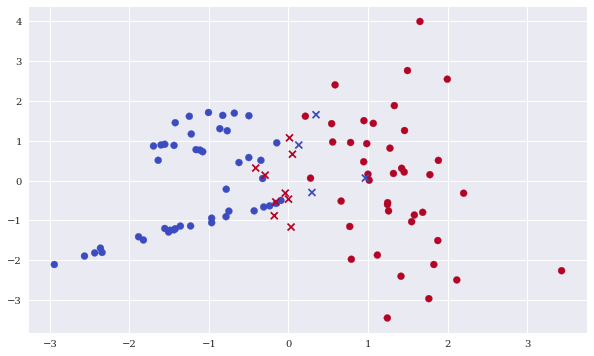

In [36]:
#可视化GNB中正确和错误的预测,红蓝表示类型，●×表示预测对错
Xc = X[y == pre] #选择正确的预测并绘图
Xf = X[y !=pre] #选择错误的预测并绘图
plt.figure(figsize=(10, 6))
plt.scatter(Xc[:,0], Xc[:,1], c=y[ y == pre], marker='o', cmap='coolwarm')
plt.scatter(Xf[:,0], Xf[:,1], c=y[ y != pre], marker='x', cmap='coolwarm')


不掉包  
参考链接： \
[https://blog.csdn.net/qwe1257/article/details/83272340?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522164881465716780271579699%2522%252C%2522scm%2522%253A%252220140713.130102334..%2522%257D&request_id=164881465716780271579699&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~top_positive~default-1-83272340.142^v5^pc_search_result_control_group,157^v4^new_style&utm_term=collections.counter&spm=1018.2226.3001.4187](https://blog.csdn.net/qwe1257/article/details/83272340?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522164881465716780271579699%2522%252C%2522scm%2522%253A%252220140713.130102334..%2522%257D&request_id=164881465716780271579699&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~top_positive~default-1-83272340.142^v5^pc_search_result_control_group,157^v4^new_style&utm_term=collections.counter&spm=1018.2226.3001.4187)

In [60]:
import numpy as np
import collections
 
#高斯朴素贝叶斯类
class GuassianNB:
    def __init__(self):
        self.prior = None #先验概率
        self.avgs = None #均值
        self.vars = None #方差值
        self.nums = None # 类别数量

    #计算先验概率
    def _get_prior(self, label: np.array)->dict:
        cnt = collections.Counter(label) # 用counter为每个类别计数
        a = {}
        for k,v in cnt.items(): # k是类别名，v是每个类别计数
            a[k]=v/len(label) # k对应的值为概率
        return a

    #计算每一类 各属性的均值,训练集有2类2属性，均值是2 * 2 array
    def _get_avgs(self,data:np.array,label:np.array)->np.array:
        return np.array([data[label == i].mean(axis=0) for i in self.nums])

    #计算每一类 各属性的方差，训练集有2类2属性，方差是2 * 2 array
    def _get_vars(self,data:np.array,label:np.array)->np.array:
        return np.array([data[label == i].var(axis=0) for i in self.nums])

    #由上两步可以知道每类其属性的分布，计算样本在每类的条件概率
    def _get_likelihood(self,row:np.array)->np.array:
        return (1 / np.sqrt(2 * np.pi * self.vars) * np.exp(
            -(row - self.avgs) ** 2 / (2 * self.vars))).prod(axis=1)
    #prod()函数用来计算所有元素的乘积，对于有多个维度的数组可以指定轴，如axis=1指定计算每一行的乘积

    #训练数据集
    def fit(self, data: np.array, label: np.array):
        self.prior = self._get_prior(label)
        print(f'不同类先验概率为{self.prior}')
        a=[]
        for key in self.prior.keys():
            a.append(key)
        self.nums = a
        self.avgs = self._get_avgs(data, label)
        self.vars = self._get_vars(data, label)

    #预测label
    def predict_prob(self, data: np.array) -> np.array:
        likelihood = np.apply_along_axis(self._get_likelihood, axis=1, arr=data)
        #print(likelihood)
        a = []
        for key in self.prior.keys():
            a.append(self.prior[key])
        probs = np.array(a) * likelihood
        print(f'前五个测试样本属于每类的可能性分别是\n{probs[:5]}')
        probs_sum = probs.sum(axis=1)
        return probs / probs_sum[:, None]

    #预测结果
    def predict(self, data: np.array) -> np.array:
        return self.predict_prob(data).argmax(axis=1) # 选取概率大的作为样本分类

def main():
    feature_dataset_train = X[:50] #特征集
    label_dataset_train = y[:50] #标签集
    feature_dataset_test = X[50:] #测试集
    label_dataset_test = y[50:] #测试结果集

    feature_dataset_test = np.array(feature_dataset_test,dtype=float)
    label_dataset_test = np.array(label_dataset_test,dtype=int)

    nb = GuassianNB()
    nb.fit(feature_dataset_train,label_dataset_train) #训练模型
    #print(nb.avgs)
    # print(nb.nums)
    # print(nb.prior)
    # print(nb.vars)
    test_result = nb.predict(feature_dataset_test)
    
    #计算精度
    acc = 0
    for i in range(len(test_result)):
        if nb.nums[test_result[i]] == label_dataset_test[i]:
            acc+=1
    print("精确度："+str(acc/len(test_result)))
if __name__ == '__main__':
    main()

不同类先验概率为{1: 0.44, 0: 0.56}
前五个测试样本属于每类的可能性分别是
[[0.0133 0.    ]
 [0.0241 0.0195]
 [0.0188 0.0445]
 [0.0294 0.0049]
 [0.0584 0.0031]]
精确度：0.88


### （3）逻辑回归 

掉包

In [1]:
from sklearn.linear_model import LogisticRegression

In [5]:
model = LogisticRegression(C=1, solver='lbfgs')
model.fit(X, y)

LogisticRegression(C=1)

In [6]:
model.predict_proba(X).round(4)[:5]

array([[0.011 , 0.989 ],
       [0.7266, 0.2734],
       [0.971 , 0.029 ],
       [0.04  , 0.96  ],
       [0.4843, 0.5157]])

In [9]:
pred = model.predict(X)
accuracy_score(y, pred)

0.9

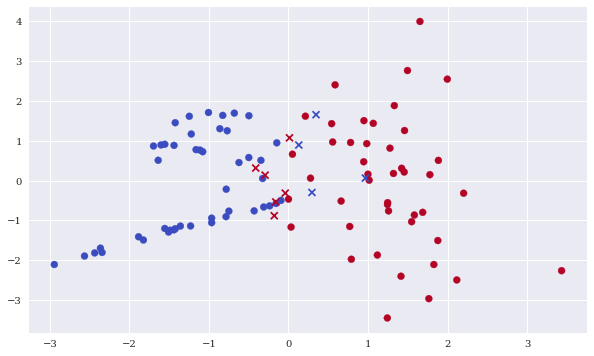

In [16]:
Xc = X[y == pred]
Xf = X[y != pred]
plt.figure(figsize=(10,6))
plt.scatter(x=Xc[:, 0], y=Xc[:, 1], c=y[y == pred],
           marker='o', cmap='coolwarm') # 预测正确的用O标记
plt.scatter(x=Xf[:,0], y=Xf[:, 1], c=y[y != pred], 
           marker='x', cmap='coolwarm') # 预测错误的用X标记，颜色表示类型

代码实现算法原理 \
计算的时候要注意！！！array和matrix的区别

In [19]:
from numpy import *

In [115]:
print(X.shape)
print(y.shape)

(100, 2)
(100,)


In [116]:
row = np.ones((100,1))


In [118]:
# 定义逻辑函数
def sigmoid(thetaX):
    return 1.0/(1+exp(-thetaX))

# 梯度下降求回归系数
def gradAscent(dataMatrix, labelMat):
    m,n = shape(dataMatrix) # m个样本，n个指标
    alpha = 0.001#定义学习率
    maxCycles = 1000 #设置迭代次数
    weights = ones((n,1)) #设置初始权重
    for k in range(maxCycles):
        h = sigmoid(dataMatrix * weights) # 每个样本的预测值
        error = h - labelMat
        temp = dataMatrix.transpose() * error #化简后的微分项
        weights = weights - alpha * temp #更新权重
    return weights

#回归函数
def LR():
    dataMatrix = mat(dataX)
    labelMat = mat(y).transpose()
    A = gradAscent(dataMatrix, labelMat)
    h = sigmoid(dataMatrix * A)
    
    #根据逻辑回归值分类
    c = []
    for arr in h.A:
        for i in arr:
            if i >0.5:
                c.append(1)
            else:
                c.append(0)
    pred = array(c)
    print(f'拟合参数为{A}') 
    print(f'逻辑回归分类为{pred}')
    
    #计算精度
    acc = 0
    for i in range(len(y)):
        if pred[i] == y[i]:
            acc+=1
    print("精确度："+str(acc/len(y)))


In [119]:
LR()

拟合参数为[[ 0.07714206]
 [ 3.39112125]
 [-0.23891673]]
逻辑回归分类为[1 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0
 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1
 1 1 1 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0]
精确度：0.91


### (4) 决策树（DT） 

### 书中案例

In [18]:
from sklearn.tree import DecisionTreeClassifier

In [21]:
model = DecisionTreeClassifier(max_depth=1)
model.fit(X, y)
DecisionTreeClassifier(class_weight=None, criterion='gini', 
                       max_depth=1,
                      max_features=None,
                      max_leaf_nodes=None,
                      min_impurity_decrease=0.0,
                      min_impurity_split=None,
                      min_samples_leaf=1,
                      min_samples_split=2,
                      min_weight_fraction_leaf=0.0,
                      presort=False,
                      random_state=None,
                      splitter='best')

DecisionTreeClassifier(max_depth=1, presort=False)

In [22]:
model.predict_proba(X).round(4)[:5]

array([[0.08, 0.92],
       [0.92, 0.08],
       [0.92, 0.08],
       [0.08, 0.92],
       [0.08, 0.92]])

In [23]:
pred = model.predict(X)

In [24]:
accuracy_score(y, pred)

0.92

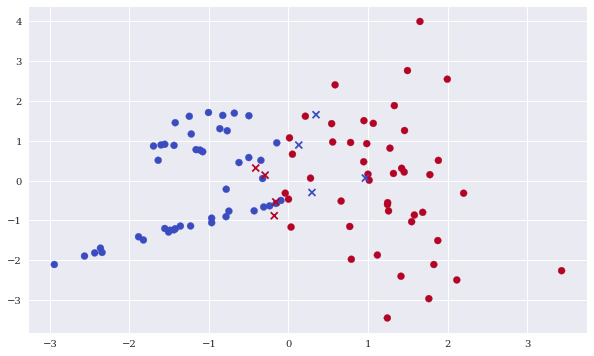

In [25]:
Xc = X[y == pred]
Xf = X[y != pred]
plt.figure(figsize=(10,6))
plt.scatter(x=Xc[:, 0], y=Xc[:, 1], c=y[y == pred],
           marker='o', cmap='coolwarm') # 预测正确的用O标记
plt.scatter(x=Xf[:,0], y=Xf[:, 1], c=y[y != pred], 
           marker='x', cmap='coolwarm') # 预测错误的用X标记，颜色表示类型

增大决策树深度

In [26]:
print('{:>8s} | {:8s}'.format('depth', 'accuracy'))
print(20 * '-')
for depth in range(1,7):
    model = DecisionTreeClassifier(max_depth=depth)
    model.fit(X, y)
    acc =accuracy_score(y, model.predict(X))
    print('{:8d} | {:8.2f}'.format(depth, acc))

   depth | accuracy
--------------------
       1 |     0.92
       2 |     0.92
       3 |     0.94
       4 |     0.97
       5 |     0.99
       6 |     1.00


### 使用乳腺癌数据进行决策树建模&决策树可视化

1. 安装安装决策树可视化包 pydot & Graphviz

In [320]:
!pip install --upgrade pydotplus

^C


In [123]:
!pip install --upgrade graphviz

2. 导入相应包

In [213]:
# 导入包
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from IPython.display import display, Image

3. 导入乳腺癌数据

In [148]:
from sklearn import datasets #sklearn中自带数据集
cancer = datasets.load_breast_cancer()

In [149]:
#sklearn数据为Bunch，转成dataframe看一眼
def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
    df['target'] = pd.Series(sklearn_dataset.target)
    return df

df_cancer = sklearn_to_df(cancer)

In [150]:
df_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [151]:
df_cancer.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


4. 决策树建模 \
用train_test_split将数据分成训练集和验证集 \
训练决策树模型并验证精度

In [152]:
#将数据划分成训练集和验证集
from sklearn.model_selection import train_test_split
data_train, data_test, target_train, target_test = train_test_split(
    cancer.data, cancer.target, test_size = 0.1, random_state = 42)

In [153]:
# 用熵进行分类
model_ENT = DecisionTreeClassifier(max_depth = None,
                                  max_features= None,
                                  criterion= 'entropy', #用来衡量分枝的质量水平
                                  min_samples_leaf= 1,
                                  min_samples_split=2)
model_ENT.fit(data_train,target_train)

DecisionTreeClassifier(criterion='entropy')

In [155]:
# 用训练集查看准确率
model_ENT.score(data_test,target_test)

0.9473684210526315

5. 决策树可视化

提取决策树并记录元素,以计算图文件保存

In [196]:
file = 'model_ENT.dot'
export_graphviz(model_ENT, out_file = file,
                feature_names = cancer.feature_names)
with open(file) as f:
    dot_graph = f.read
    graphviz.Source(dot_graph)

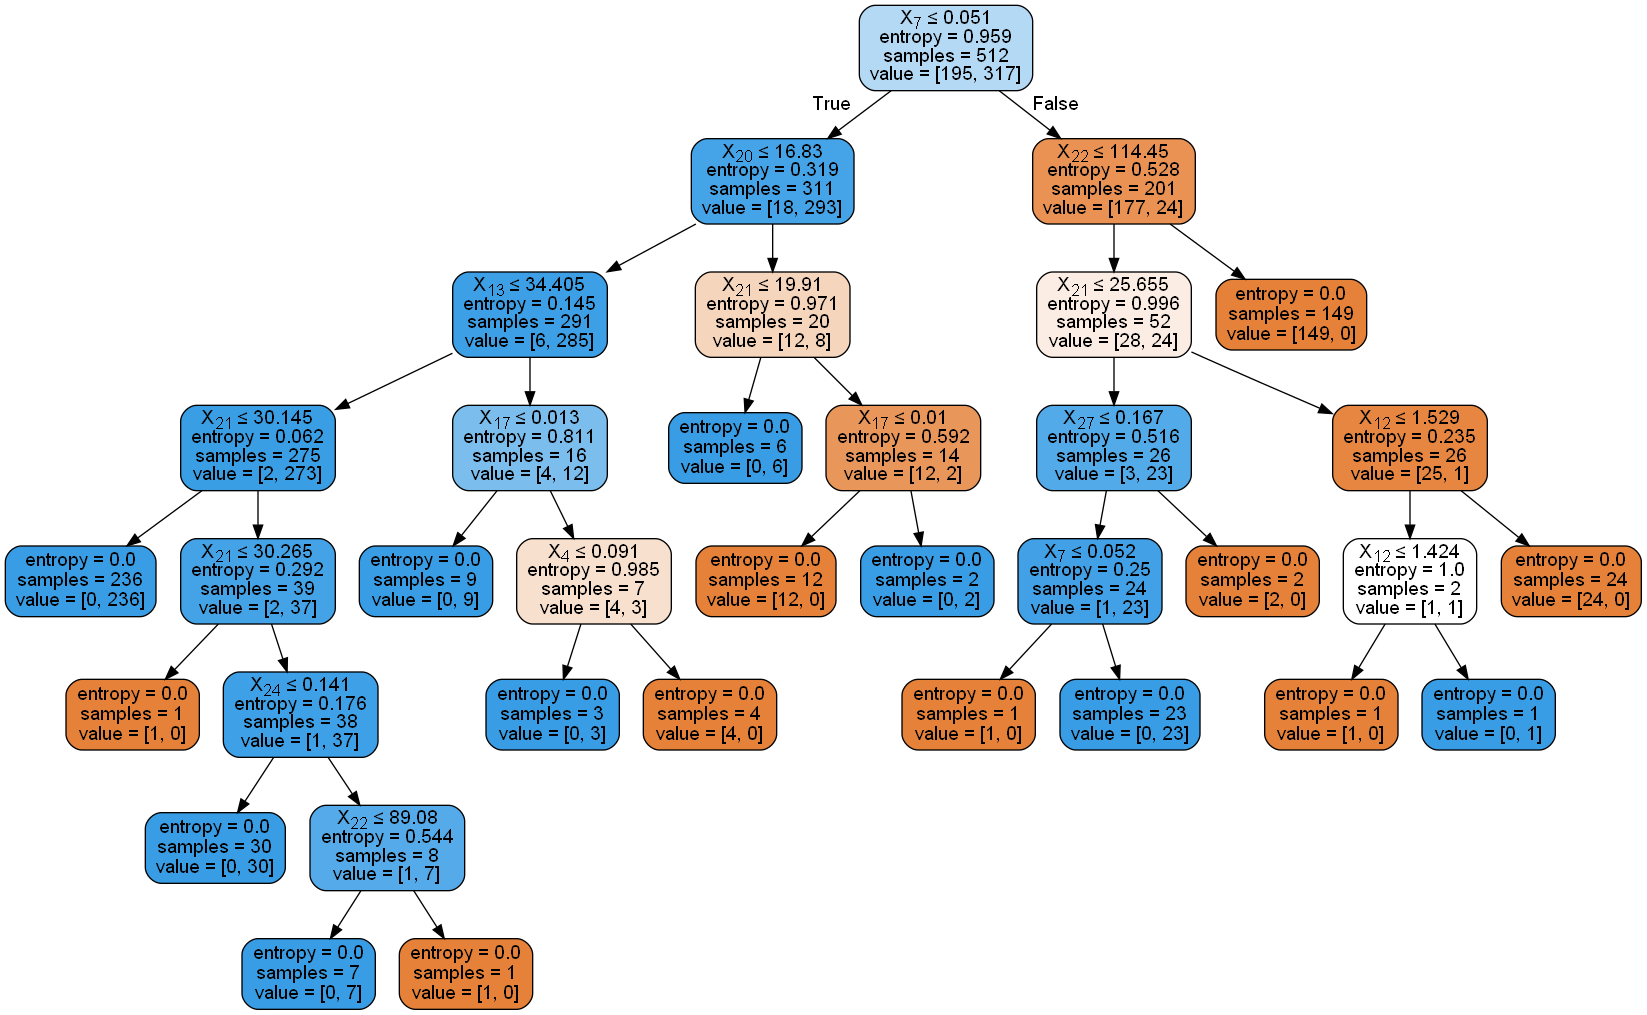

In [210]:
dot_data = tree.export_graphviz(model_ENT,out_file=None,filled=True,rounded=True,special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
display(Image(graph.create_png()))

6. 可视化遇到的困难 \
`      若Python中运行仍然出错：’ExecutableNotFound: failed to execute ['dot', '-Tpdf', '-O', 'iris'], 
make sure the Graphviz executables are on your systems' PATH‘
` \
需要将graphviz的bin路径添加到环境中 \
`https://blog.csdn.net/qq_40304090/article/details/88594813?spm=1001.2101.3001.6650.2
&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-2.pc_relevant_paycolumn_v3&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-2.pc_relevant_paycolumn_v3`

In [209]:
import os
os.environ["PATH"] += os.pathsep + 'D:/program files/Graphviz/bin/'

### (5) 深度神经网络 （DNN）

用sklearn

In [27]:
from sklearn.neural_network import MLPClassifier

In [28]:
model = MLPClassifier(solver='lbfgs',
                     alpha=1e-5,
                     hidden_layer_sizes=2 * [75],
                     random_state=10)

In [35]:
model.fit(X,y)
MLPClassifier(activation='relu', 
             alpha=1e-05,
             batch_size='auto',
             beta_1=0.9,
             beta_2=0.999,
             early_stopping=False,
             epsilon=1e-08,
             hidden_layer_sizes=[75, 75],
             learning_rate='constant',
             learning_rate_init=0.001,
             max_iter=200,
             momentum=0.9,
             n_iter_no_change=10,
             nesterovs_momentum=True,
             power_t=0.5,
             random_state=10,
             shuffle=True,
             solver='lbfgs',
             tol=0.0001,
             validation_fraction=0.1,
             verbose=False,
             warm_start=False)
pred = model.predict(X)
pred

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


array([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0])

In [36]:
accuracy_score(y, pred)

1.0

完整的神经网络
<span style="border-bottom:3px dashed #DE7171;">代码来自《python神经网络编程》</span>

In [250]:
    # neural network class definition
    class neuralNetwork :        # initialise the neural network
        def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate) :
            # set number of nodes in each input, hidden, output layer
            self.inodes =inputnodes
            self.hnodes =hiddennodes
            self.onodes =outputnodes

            # link weight matrices, wih and who
            # weights inside the arrays are w_i_j, where link is from node i to node j in the next layer
            # w11 w21
            # w12 w22 etc
            self.wih =numpy.random.normal(0.0, pow(self.hnodes, -0.5),
                                          (self.hnodes, self.inodes))
            self.who =numpy.random.normal(0.0, pow(self.onodes, -0.5),
                                          (self.onodes, self.hnodes))

            # learning rate
            self.lr =learningrate

            # activation function is the sigmoid function
            self.activation_function =lambda x: scipy.special.expit(x)

            pass
        # train the neural network
        
        def train(self, inputs_list, targets_list) :          # convert inputs list to 2d array
            inputs =numpy.array(inputs_list, ndmin=2).T
            targets =numpy.array(targets_list, ndmin=2).T

            # calculate signals into hidden layer
            hidden_inputs =numpy.dot(self.wih, inputs)
            # calculate the signals emerging from hidden layer
            hidden_outputs =self.activation_function(hidden_inputs)

            # calculate signals into final output layer
            final_inputs =numpy.dot(self.who, hidden_outputs)
            # calculate the signals emerging from final output layer
            final_outputs =self.activation_function(final_inputs)
            # output layer error is the (target - actual)
            output_errors =targets - final_outputs
            # hidden layer error is the output_errors, split by weights,recombined at hidden nodes
            hidden_errors =numpy.dot(self.who.T, output_errors)

            # update the weights for the links between the hidden and output layers
            self.who +=self.lr * numpy.dot((output_errors * 
                                            final_outputs * (1.0- final_outputs)),
                                           numpy.transpose(hidden_outputs))

            # update the weights for the links between the input and hidden layers
            self.wih +=self.lr * numpy.dot((hidden_errors * 
                                          hidden_outputs  (1.0- hidden_outputs)), numpy.transpose(inputs))
            pass
        
        # query the neural network
        
        def query(self, inputs_list) :          # convert inputs list to 2d array
            inputs =numpy.array(inputs_list, ndmin=2).T

            # calculate signals into hidden layer
            hidden_inputs =numpy.dot(self.wih, inputs)
            # calculate the signals emerging from hidden layer
            hidden_outputs =self.activation_function(hidden_inputs)

            # calculate signals into final output layer
            final_inputs =numpy.dot(self.who, hidden_outputs)
            # calculate the signals emerging from final output layer
            final_outputs =self.activation_function(final_inputs)

            return final_outputs

### 6.特征空间变换

In [251]:
from sklearn import preprocessing

In [252]:
X[:5]

array([[ 1.68762365, -0.79757726],
       [-0.4312405 , -0.76063089],
       [-1.43934486, -1.23632519],
       [ 1.11799425, -1.86821958],
       [ 0.05020412,  0.65899067]])

1.z-score标准化（对每一列进行变换） \
将特征数据变换为均值为0、单位方差的标准正态分布数据（可适应于不知道最大值和最小值的情况）
$$ y_{i}=\frac{x_{i}-\mu}{\sigma}, i \in[1, n] $$

In [254]:
Xs = preprocessing.StandardScaler().fit_transform(X)
Xs[:5]

array([[ 1.28814988, -0.54885303],
       [-0.33836772, -0.52155672],
       [-1.11222549, -0.87300391],
       [ 0.85088152, -1.33985312],
       [ 0.03120677,  0.52727234]])

2.Min-max标准化（对每一列进行变换） \
通过最大值和最小值，将数据中的每个值转化为【0，1】之间的数据 \
对于正向指标公式：
$$
y_{i}=\frac{x_{i}-\min (x)}{\max (x)-\min (x)}, i \in[1, n]
$$
对于逆向指标：
$$
y_{i}=\frac{\max (x)-x_{i}}{\max (x)-\min (x)}, i \in[1, n]
$$

In [255]:
Xm = preprocessing.MinMaxScaler().fit_transform(X)
Xm[:5]

array([[0.72620338, 0.35629123],
       [0.39392563, 0.3612627 ],
       [0.2358359 , 0.29725366],
       [0.63687477, 0.21222646],
       [0.4694252 , 0.55228583]])

3. 范数标准化 (对每一行做处理)\
L1 norm 是指对每个样本的每一个元素都除以该样本的L1范数.
$$
\|\mathbf{x}\|_{l1}=\sum_{i=1}^{n}\left|x_{i}\right|
$$
L2 norm 是指对每个样本的每一个元素都除以该样本的L2范数.
$$| | x | | 2 = \sqrt { \sum _ { i = 1 } ^ { n } x _ { i } ^ { 2 } }$$

In [259]:
# Xn1[0][0] = X[0][0] / ( X[0][0]+X[0][1] ) = 1.68762365 /  (1.68762365, + 0.79757726)
Xn1 = preprocessing.Normalizer(norm='l1').transform(X)
Xn1[:5]

array([[ 0.6790693 , -0.3209307 ],
       [-0.36181798, -0.63818202],
       [-0.5379381 , -0.4620619 ],
       [ 0.37438519, -0.62561481],
       [ 0.07079031,  0.92920969]])

In [257]:
Xn2 = preprocessing.Normalizer(norm='l2').transform(X)
Xn2[:5]

array([[ 0.90411541, -0.42728833],
       [-0.49319983, -0.86991604],
       [-0.75857884, -0.65158126],
       [ 0.51350334, -0.8580876 ],
       [ 0.07596323,  0.99711062]])

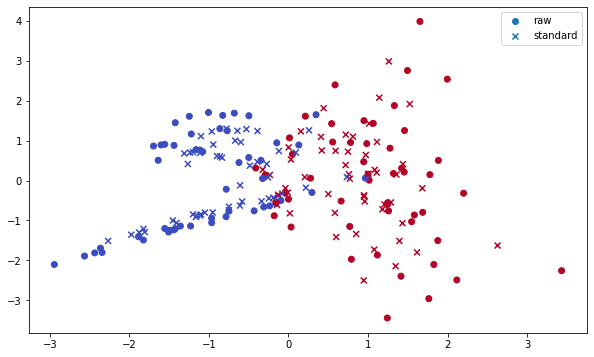

In [264]:
from pylab import  plt
plt.figure(figsize=(10,6))
markers = ["o","x"]
data_sets = [X, Xs]
labels = ['raw','standard']
for x, m, l in zip(data_sets, markers, labels):
    plt.scatter(x=x[:,0], y=x[:,1],c=y,marker=m, cmap='coolwarm', label=l)
    plt.legend()

4. Binarizer \
根据阈值将数值型转变为二进制型

In [308]:
X[:5]

array([[ 1.68762365, -0.79757726],
       [-0.4312405 , -0.76063089],
       [-1.43934486, -1.23632519],
       [ 1.11799425, -1.86821958],
       [ 0.05020412,  0.65899067]])

In [310]:
 #将小于等于1的数值转为0，大于1的转为1,将连续数值离散化
Xb = preprocessing.Binarizer(threshold=1).fit_transform(X)
Xb[:5]

array([[1., 0.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 0.]])

In [313]:
Xd = np.digitize(X, bins=[-1, 0, 1])#bins一维单调数组，必须是升序或者降序
#<-1返回0，[-1,0）返回1，[0,1)返回2，[1,)返回3
Xd[:5]

array([[3, 1],
       [1, 1],
       [0, 0],
       [3, 0],
       [2, 2]], dtype=int64)

### （7）支持向量机 

In [318]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [315]:
bins = np.linspace(-4.5, 4.5, 50)
Xd = np.digitize(X, bins=bins) #将连续特征离散化变成分类特征
Xd[:5]

array([[34, 21],
       [23, 21],
       [17, 18],
       [31, 15],
       [25, 29]], dtype=int64)

In [316]:
train_x, test_x, train_y, test_y = train_test_split(Xd, y ,
                                                    test_size=0.33, 
                                                    random_state=0)

In [319]:
print('{:>8s} | {:8s}'.format('kernel','accuracy'))
print(20 * '-')
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    model = SVC(C=1, kernel=kernel, gamma='auto')
    model.fit(train_x, train_y)
    acc = accuracy_score(test_y, model.predict(test_x))
    print('{:>8s} | {:8.3f}'.format(kernel, acc))

  kernel | accuracy
--------------------
  linear |    0.848
    poly |    0.758
     rbf |    0.788
 sigmoid |    0.455
